In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree, ensemble 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

from IPython.display import display as dsp
from IPython.display import Image

import pydotplus
import graphviz
import time

import sklearn
print(sklearn.__version__)

0.20.3


In [2]:
def model_validate(mod, X, Y):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =  0.2)
    
    start_time = time.time()
    mod.fit(X_train, Y_train)
    print('Training time:\n{} s'.format(time.time() - start_time))
    
    print('\n20% holdout score:\n{}'.format(mod.score(X_test, Y_test)))
    
    print('\nFold Scores:\n}{}'.format(cross_val_score(mod, X, Y, CV = 5)))
    
    Y_pred = mod.predict(X)
    
    print('\nConfusion Matrix:\n{}'.format(confusion_matrix(Y, Y_pred)))

# Google Play Store: An Analysis

__Our Data__

We have data on nearly ten thousand apps on the google play store. We want to create a moded that will anticipate how the app will be received given certain criteria. This kind of data would be useful for app developers to know what apps to invest time and resources into.

To begin our investigation, we will need to import our datasets. We have two datasets that may be useful: google play store reviews and google play store apps. Lets explore the data:

In [3]:
gps_raw = pd.read_csv('data/googleplaystore.csv')
ur_raw = pd.read_csv('data/googleplaystore_user_reviews.csv')

gps_raw.dropna(inplace = True)

dsp(gps_raw.head())
dsp(ur_raw.head())

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [4]:
#Compare the two datasets:
print('Apps data shape:\n{}'.format(gps_raw.shape))
print('Review data shape:\n{}'.format(ur_raw.shape))

isin = 0
isnotin = 0

review_apps = ur_raw['App'].unique()
ps_apps = gps_raw['App'].unique()

for app in review_apps:
    if app in ps_apps:
        isin += 1
    else:
        isnotin += 1
        
print('\n{} of {} apps from the app data set are represented in the reviews.'.format(isin, len(gps_raw['App'].unique())))

Apps data shape:
(9360, 13)
Review data shape:
(64295, 5)

1020 of 8190 apps from the app data set are represented in the reviews.


Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')
App
8190
Category
33
Reviews
5990
Size
413
Installs
19
Type
2
Price
73
Content Rating
6
Genres
115
Last Updated
1299
Current Ver
2638
Android Ver
31
Number of unique ratings:  39


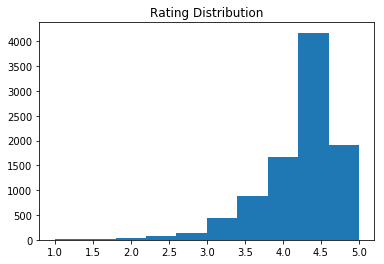

In [5]:
#Explore what we have to work with
#print('Payment Types:\n{}'.format(gps_raw['Type'].unique()))
print(gps_raw.columns)

categorical = gps_raw.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

    
print('Number of unique ratings: ', len(gps_raw['Rating'].unique()))
plt.hist(gps_raw['Rating'])
plt.title('Rating Distribution')
plt.show()

## The Data

Interestingly, the 'reviews' data seems to include the results of some prior work with machine learning, as there appears to be score columns for their sentiments. There could be some utility in including features from the review, there isn't enough overlap between the apps represented in both datasets to warrant this inclusion.

One thing to note is how many of these potential features are categorical. To deal with this, we will need to create dummy columns which will act as binary features indicating if a given app belongs to a given category. This will increase the number of columns we have considderably, but since most of these columns will be mutually exclusive, we aren't actually adding that many features. Informational entropy will take care of this.

The first problem with our data we will need to tackle is our data's negative skew. We will tackle this by reducing the number of classes to two: positive (>= 4.5) and negative (< 4.5). We will represent these as a binary outcome (0, 1) this will allow future work to do more nuanced anaylsis (ie sentiment analysis on a gradient scale as opposed to a strict class-based outcome).


Number of Normalized Classes:  2


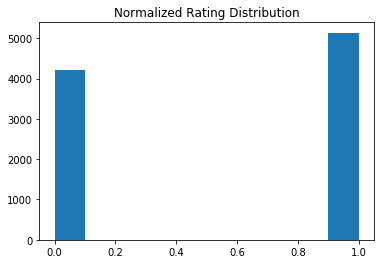

In [17]:
#Y = round(gps_raw['Rating'] ** 3, 2)

Y = gps_raw['Rating']

Y_normed = Y.apply(lambda x: np.where(x >= 4.3, 1, 0))

print('Number of Normalized Classes: ', len(Y_normed.unique()))

plt.hist(Y_normed)
plt.title('Normalized Rating Distribution')
plt.show()

## The Decision Tree Model

Now that we have normalized our outcomes, we can now create our training data and instantiate our models. Since much of our data is categorical, we will need to create 

In [18]:
#Select categorical data we want
#cat = gps_raw[['Category', 'Installs', 'Content Rating']]

#Create Columns
data = gps_raw[['Category', 'Rating', 'Installs', 'Content Rating', 'Genres']]

#Cast columns w/numeric data to a numeric type
data['Reviews'] = gps_raw['Reviews'].astype(int)
data['Price'] = gps_raw['Price'].str.replace('$', '').astype(float)

#Create dummy variables for binary features
data = pd.get_dummies(data)

print('Final dataframe shape:\n{}'.format(data.shape))

Final dataframe shape:
(9360, 176)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
col_read = False

if col_read == True:
    for col in data.columns:
        print(col)
        
#Set up Features, outcomes
#Here we pass in our normalized outcome 'Y'
X = data.drop(columns = ['Rating'])
Y_num = Y
Y_cat = Y_normed.astype(str)

print('Possible outcomes:\n{}'.format(Y_cat.unique()))

Possible outcomes:
['0' '1']


In [ ]:
#Lets make a decision tree



#Render Tree
#dot_data = tree.export_graphviz(
#    dt_cls, out_file=None,
#    feature_names=X.columns,
#    class_names=Y_cat.unique(),
#    filled=True
#)

#graph = pydotplus.graph_from_dot_data(dot_data)
#dsp(Image(graph.create_png()))

In [24]:
start_time = time.time()

dt_cls = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_features=8,
    max_depth=8
    #random_state = 10
)

dt_cls.fit(X, Y_cat)

#Model Score
print('\nModel Score: ',dt_cls.score(X, Y_cat))

#Model Validation
print('\nFold Scores:\n', cross_val_score(dt_cls, X, Y_cat, cv = 5))

#Confusion matrix
Y_cat_pred = dt_cls.predict(X)
print('\nConfusion Matrix:\n', confusion_matrix(Y_cat, Y_cat_pred))

print("\n\n--- %s seconds ---" % (time.time() - start_time))

#model_validate(dt_cls, X, Y)


Model Score:  0.6516025641025641

Fold Scores:
 [0.6038441  0.604378   0.65010684 0.57883485 0.59112774]

Confusion Matrix:
 [[3512  710]
 [2551 2587]]


--- 0.512152910232544 seconds ---


__Decision Tree Analysis__

Wow, that is pretty terrible! While the accuracy appears pretty high (~71%), our decision tree only seems to recognize two classes.

Although they are among the most intuitive models available, individual decision trees do not make very strong learners. Decision trees are best used in ensemble modeling, where you have numerous models that have a vote on what class a given observation should be. So next, we will generate an ensemble model called a "Random Forest".

## The Random Forest Model

A random forest consists of numerous decision trees each trained on their own section of data. Each tree has a vote in deciding what class an observation belongs to.

In [21]:
start_time = time.time()

clf = ensemble.RandomForestClassifier(n_estimators = 100)
clf.fit(X, Y_cat)

#Model Score
print('\nModel Score: ',clf.score(X, Y_cat))

#Validation
print('\nFold Scores:\n', cross_val_score(clf, X, Y_cat, cv = 5))

#Confusion Matrix
Y_clf_pred = clf.predict(X)
print('\nConfusion Matrix:\n', confusion_matrix(Y_cat, Y_clf_pred))

print("\n\n--- %s seconds ---" % (time.time() - start_time))


Model Score:  0.9842948717948717

Fold Scores:
 [0.67716115 0.72237053 0.66969535 0.6322822  0.65740246]

Confusion Matrix:
 [[  14    1    0    1    4]
 [   1  113    2    8    6]
 [   0    0  554   21    7]
 [   2    1    9 6663   36]
 [   0    2    7   39 1869]]


--- 10.369795799255371 seconds ---


__Random Forest Analysis__

Overfitting is readlily apparent in this classifier out of the box, this will require some tuning.

In [22]:
start_time = time.time()

clf_rev = ensemble.RandomForestClassifier(n_estimators = 200)
clf_rev.fit(X, Y_cat)

#Model Score
print('\nModel Score: ',clf_rev.score(X, Y_cat))

#Validation
print('\nFold Scores:\n', cross_val_score(clf_rev, X, Y_cat, cv = 5))

#Confusion Matrix
Y_clf_rev_pred = clf_rev.predict(X)
print('\nConfusion Matrix:\n', confusion_matrix(Y_cat, Y_clf_rev_pred))

print("\n\n--- %s seconds ---" % (time.time() - start_time))


Model Score:  0.9845085470085471

Fold Scores:
 [0.67609392 0.72076882 0.67022982 0.63762694 0.65098878]

Confusion Matrix:
 [[  13    1    0    3    3]
 [   1  117    1    5    6]
 [   0    2  550   20   10]
 [   0    3    8 6657   43]
 [   1    3    4   31 1878]]


--- 21.8574001789093 seconds ---


## Boosting Models

There is one other way we can engineer a model using decision trees, and that is with the use of gradient boosting.

Gradient boosting a type of ensemble modeling in which a number of simple trees (one for each class in the outcome) are trained on the data, each deciding if a given observation belongs to their category or not. The observations that the system incorrectly identified are used as the next training set. This process then iterates until it minimizes the loss.

In [ ]:
start_time = time.time()

gbc = ensemble.GradientBoostingClassifier(learning_rate = 0.1)
gbc.fit(X, Y_cat)

#Validation

#Model Score:
print('\nModel Score: ',gbc.score(X, Y_cat))

#Fold Scores:
print('\nFold Scores:\n', cross_val_score(gbc, X, Y_cat, cv = 5))

#Confusion Matrix
Y_gbc_pred = gbc.predict(X)
print('\nConfusion Matrix:\n', confusion_matrix(Y_cat, Y_gbc_pred))

print("\n\n--- %s seconds ---" % (time.time() - start_time))

__Analysis__

These are the best results yet! Errors are fairly distributed accross all categories, and we have fairly high accuracies in our cross validation scores (between 71% and 74%).